In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_ts
from warnings import simplefilter
simplefilter("ignore")

In [2]:
df = get_ts(days=720)
df.head(3)

,prices,market_caps,total_volumes
dates,,,
2019-11-02,0.084327,4.722326e+07,8.664169e+06
2019-11-03,0.084479,4.726148e+07,8.724440e+06
2019-11-04,0.089416,5.003882e+07,9.235387e+06


In [3]:
# Serial dependence
# https://www.kaggle.com/ryanholbrook/time-series-as-features
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

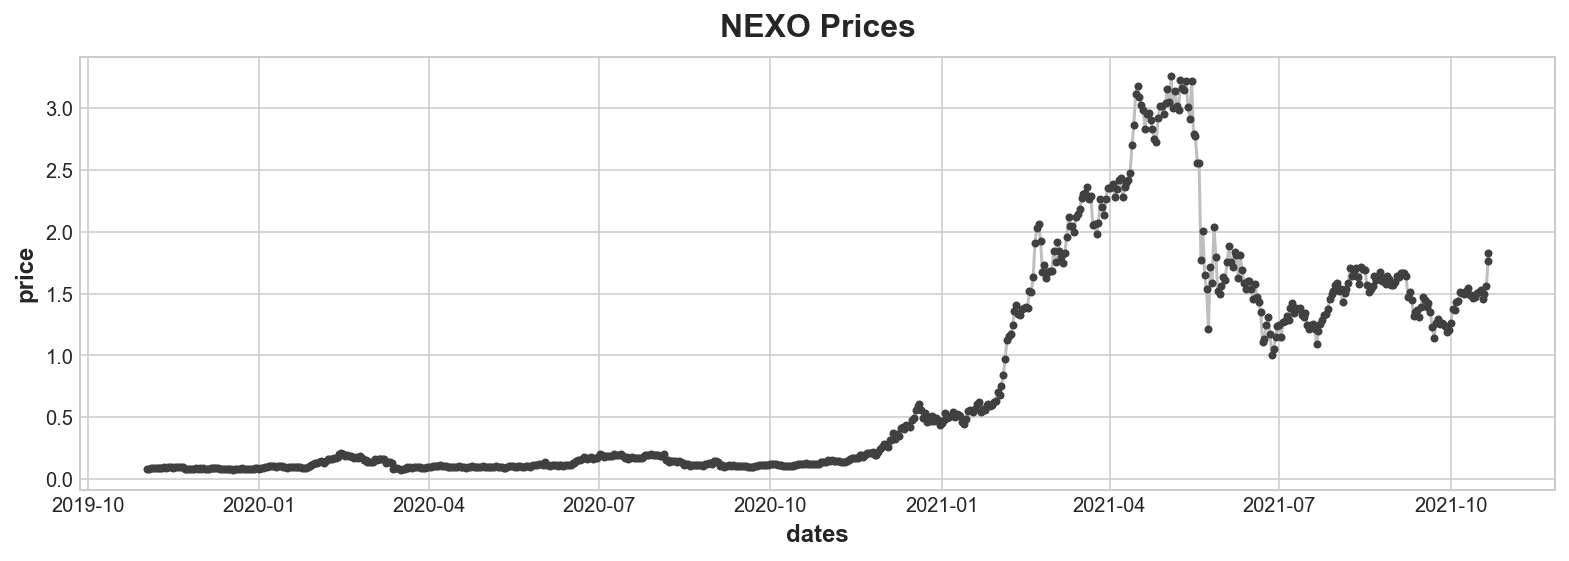

In [4]:
ax = df.prices.plot(title='NEXO Prices', **plot_params)
_ = ax.set(ylabel="price")

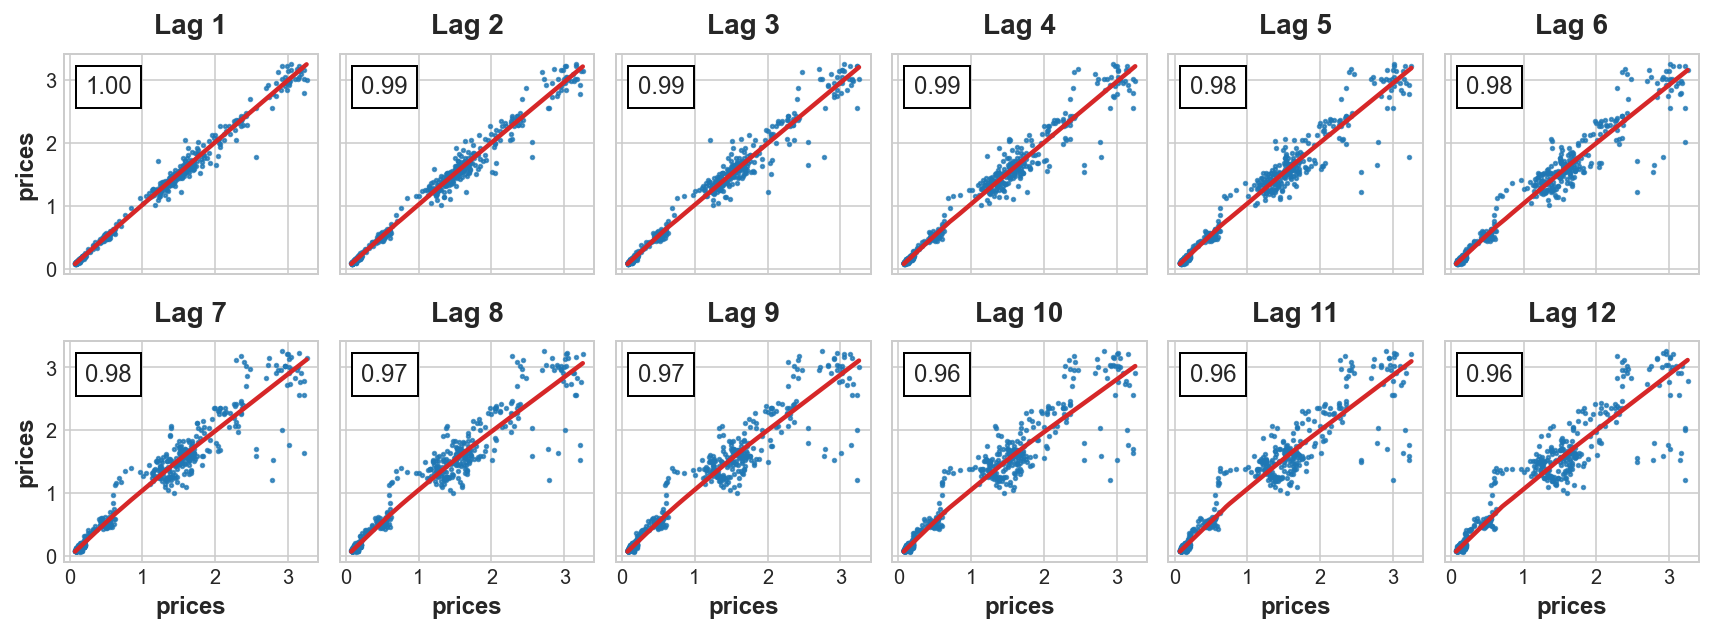

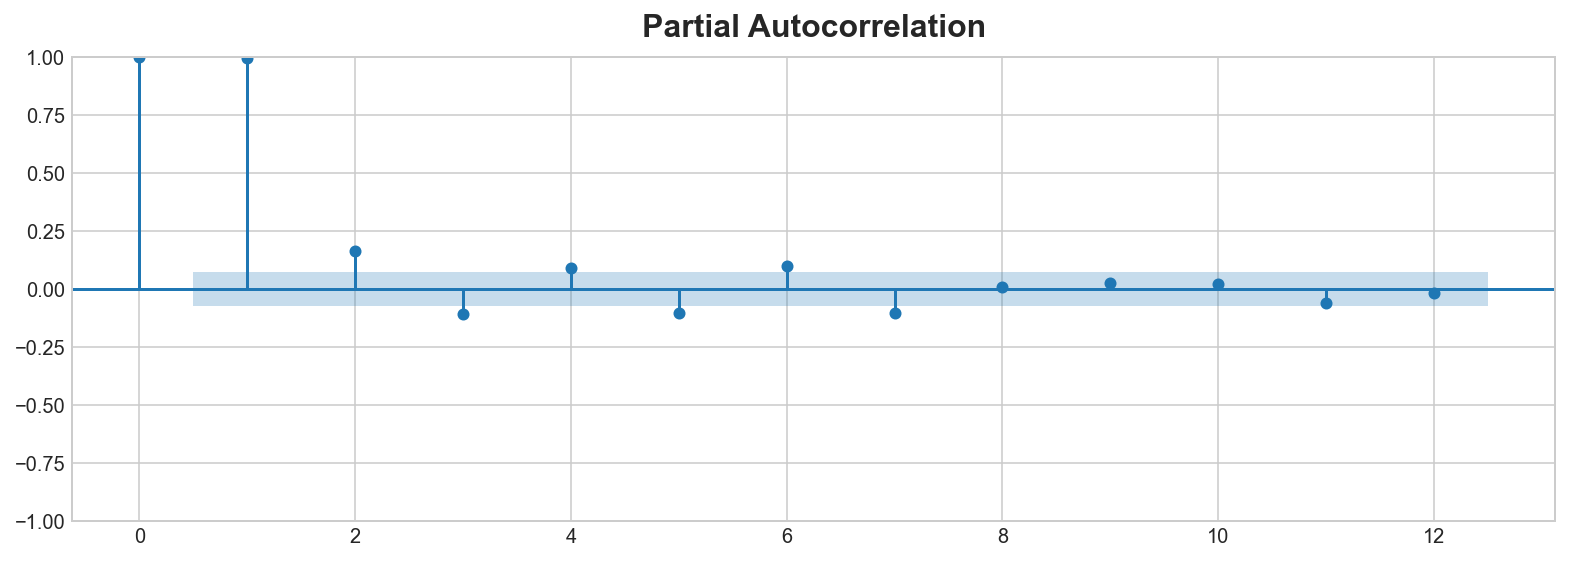

In [5]:
_ = plot_lags(df.prices, lags=12, nrows=2)
_ = plot_pacf(df.prices, lags=12)

We may use all lags until 7.

In [6]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df.prices, lags=7)
X = X.fillna(0.0)

X.head(3)

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7
dates,,,,,,,
2019-11-02,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2019-11-03,0.084327,0.000000,0.0,0.0,0.0,0.0,0.0
2019-11-04,0.084479,0.084327,0.0,0.0,0.0,0.0,0.0


In [7]:
y = df.prices.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

In [8]:
X_test.head(3)

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7
dates,,,,,,,
2021-08-24,1.645399,1.609613,1.642004,1.557085,1.536667,1.514128,1.570321
2021-08-25,1.671302,1.645399,1.609613,1.642004,1.557085,1.536667,1.514128
2021-08-26,1.602531,1.671302,1.645399,1.609613,1.642004,1.557085,1.536667


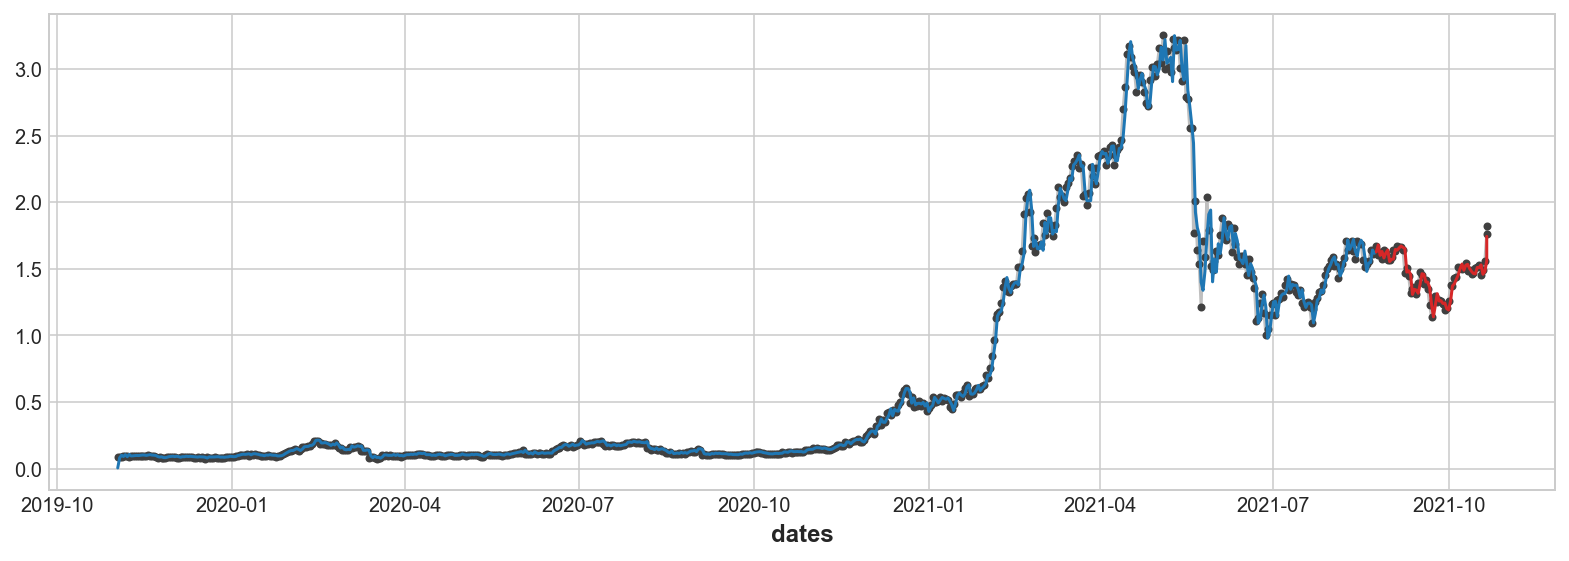

In [9]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

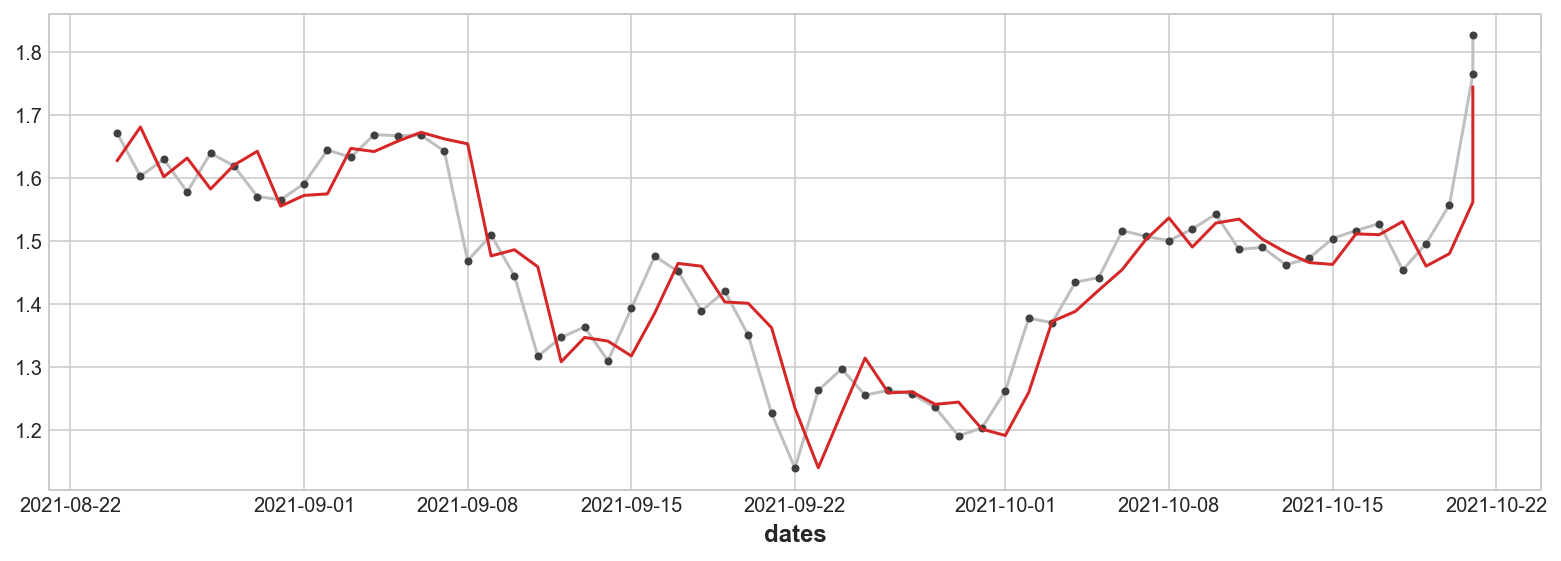

In [10]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

The current "lag-model" needs is adapting too slowly. It seems like the predicted price is always one day behind the current price. Some leading indicators are needed (additional features)

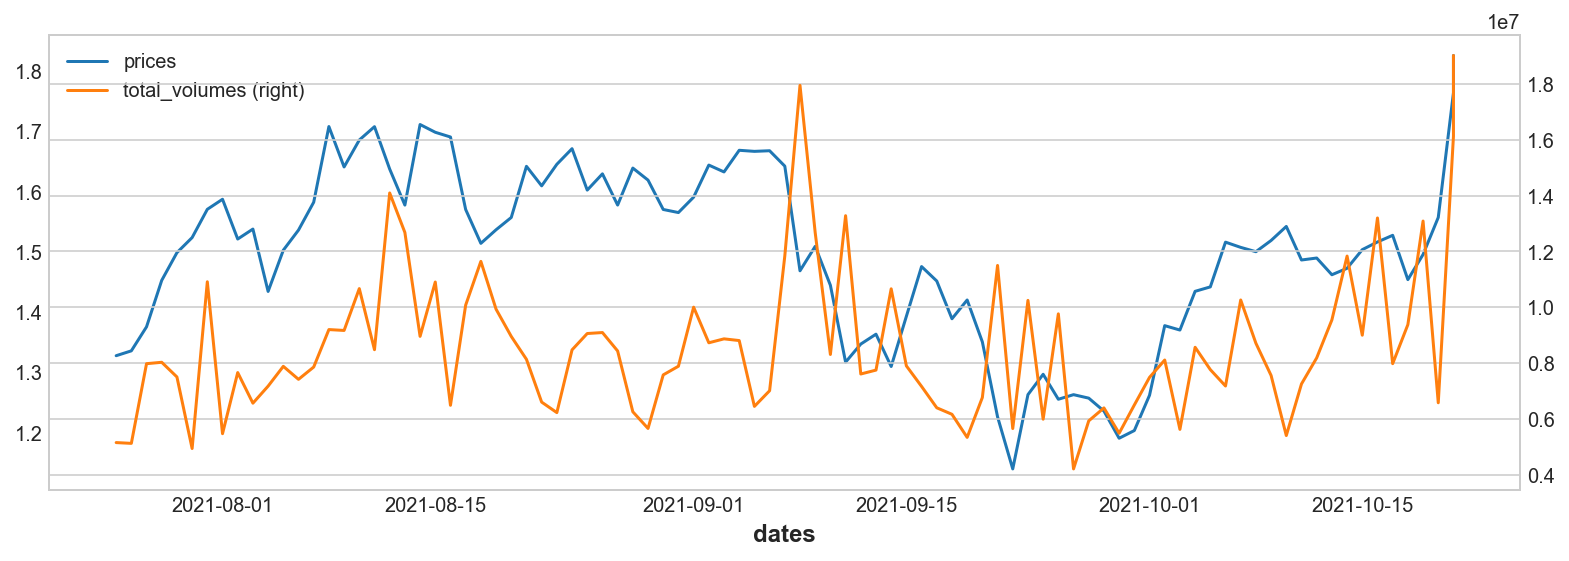

In [20]:
ax = df.iloc[-90:].plot(
    y=["prices", "total_volumes"],
    secondary_y="total_volumes",
)

In [23]:
additional_features = ["market_caps", "total_volumes"]
# Create three lags for each search term
X0 = make_lags(df[additional_features], lags=6)

# Create four lags for the target, as before
X1 = make_lags(df.prices, lags=7)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

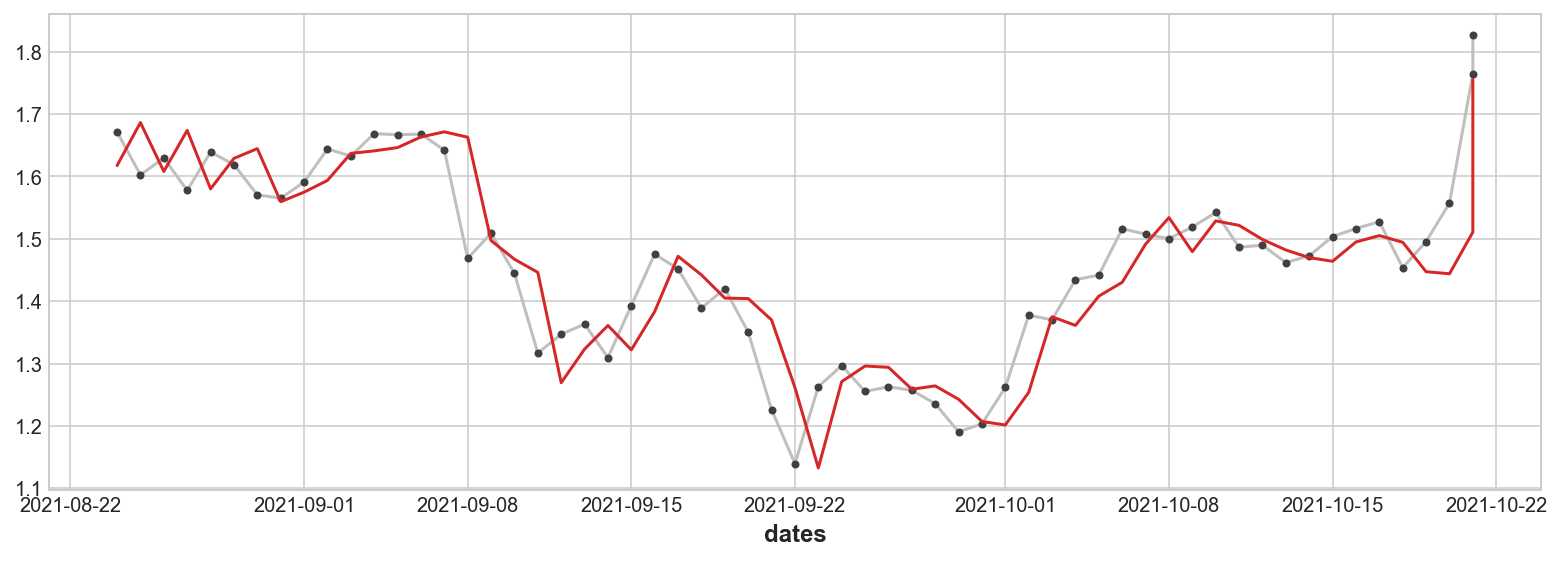

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Our model seems still bad. However, we could easily add other cryptos as well. Often Bitcoin is THE currency all other cryptos adopt to (highly correlated).

In [26]:
# Statistical features
mean_7 = X.y_lag_1.rolling(7).mean()
median_14 = X.y_lag_1.rolling(14).median()
std_7 = X.y_lag_1.rolling(7).std()

X = pd.concat([X, mean_7, median_14, std_7], axis=1).fillna(0.0)

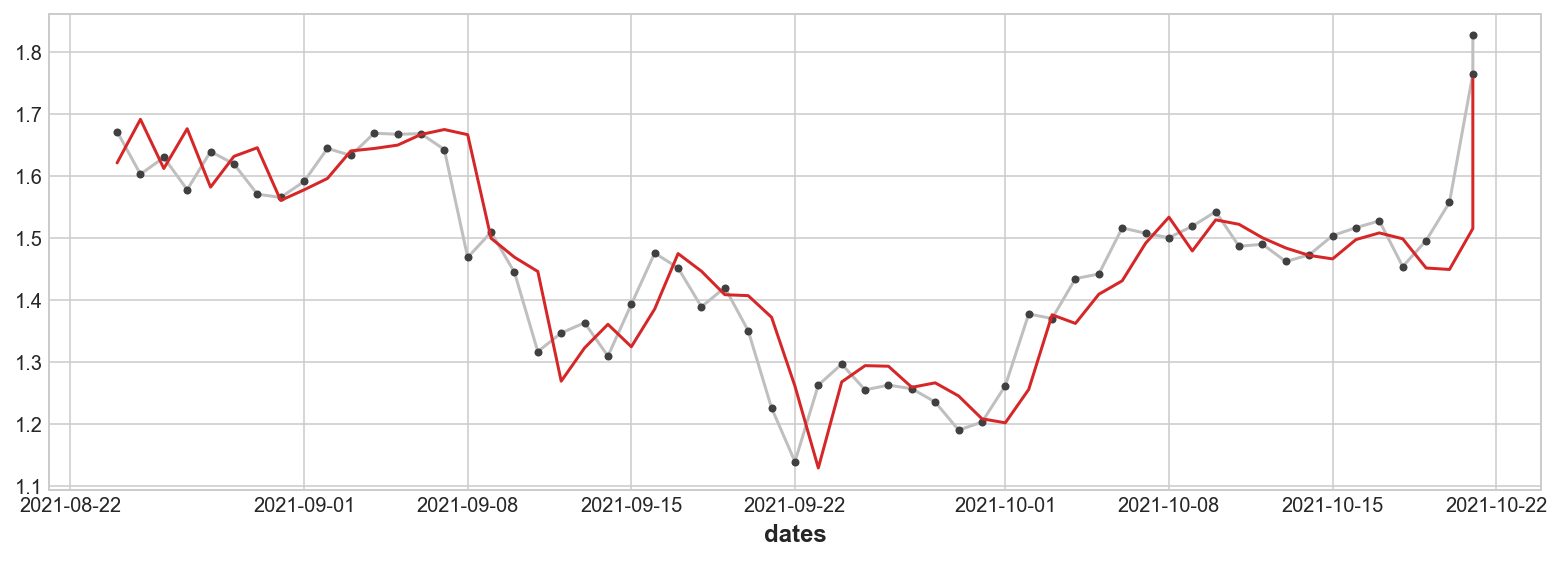

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

After adding statistical features the model improved slightly, but still isn't that good ;)